In [183]:
import numpy as np

from scipy import stats

from prysm import (
    coordinates,
    convolution,
    detector,
    geometry,
    propagation,
    polynomials,
    objects,
)

from matplotlib import pyplot as plt
from matplotlib import image as mpimg

import PIL

First, we define a bunch of parameters and set up the basic representation of the pupil:

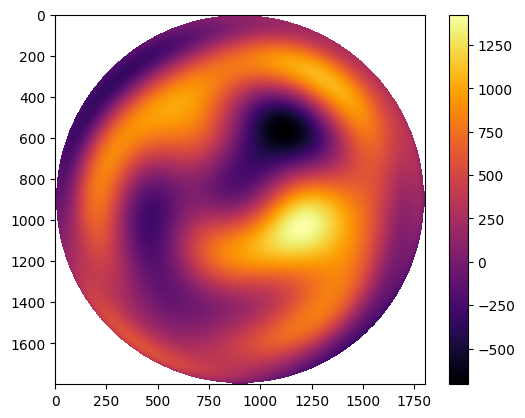

In [184]:
pp = 4.5
# res = 512
fno = 1.8
efl = 100
epd = efl/fno
r_aper = epd / 2

xi, eta = coordinates.make_xy_grid(1800, diameter=epd)
r, t = coordinates.cart_to_polar(xi,eta)
dx = xi[0,1] - xi[0,0]

r_aber = r / r_aper

amp = geometry.circle(r_aper, r)

nms = [polynomials.noll_to_nm(j) for j in range(1,12)]
basis = list(polynomials.Q2d_sequence(nms, r_aber, t))

phs_coefs = np.random.rand(len(basis)) * 2000

phs = polynomials.sum_of_2d_modes(basis, phs_coefs)

# only used for plotting
mask = amp == 0
phs2 = phs.copy()
phs2[mask] = np.nan
im = plt.imshow(phs2, cmap='inferno')
plt.colorbar(im)

Note carefully the use of r_aber when computing the basis – the polynomials are defined on 
, which necessitates this normalization. We’ve used the smallest possible grid that can contain the pupil with no padding, and a large number of samples. A requirement of the matrix triple product DFT is that the output resolution, divided by Q, must not exceed the input resolution. If this is not honored, then Dirichlet clones of the PSF will be visible in the edge of the array, which is unphysical and incorrect. Since we will have 3584 px on the output and Q~=2.1, we need about 1800 px on the input,

<StemContainer object of 3 artists>

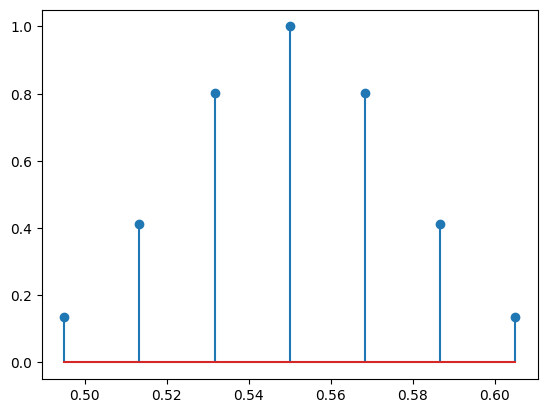

In [185]:
wvl0 = .550
halfbw = 0.1
wvls = np.linspace(wvl0*(1-halfbw), wvl0*(1+halfbw), 7)

def gauss(x, mu, sigma):
    num = (x-mu)**2
    den = 2 * sigma ** 2
    return np.exp(-num/den)

spectral_weights = gauss(wvls, .550, .550*.05)
plt.stem(wvls, spectral_weights)

Having now completed the bulk of the preparatory work, we can now compute the PSF associated with this OPD and this spectrum. We’ll propagate each wavelength to the oversampled grid:

In [186]:
psfs = []
for wvl in wvls:
    pup = propagation.Wavefront.from_amp_and_phase(amp, phs, wvl, dx)
    tmp = pup.focus_fixed_sampling(efl, pp/7, 3584)
    psfs.append(tmp.intensity.data)

# re-use this function, identical behavior
psf = polynomials.sum_of_2d_modes(psfs, spectral_weights)

# norm to sum of 1, no loss or creation of energy from convolution
psf /= psf.sum()

After producing the PSF, we need to rasterize the target. For this, we need a new grid:

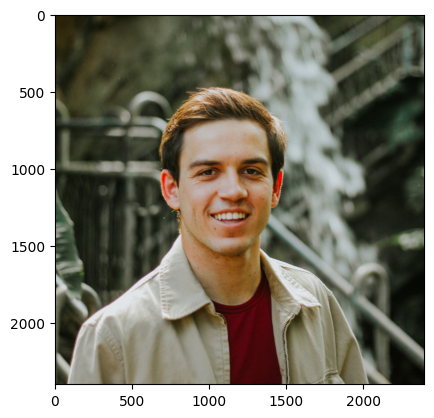

In [187]:
image = mpimg.imread('IMG_8916.jpg')
plt.imshow(image)
plt.show()

In [188]:
image = PIL.Image.open('IMG_8916.jpg')
# resize image so short side is 512 pixels
size = image.size
scale = 3584/min(size)
image = image.resize((int(size[0]*scale), int(size[1]*scale)))
# convert to grayscale
image = image.convert('L')
data = np.asarray(image)
image2 = PIL.Image.fromarray(data)
image2.show()
# normalize to 0-1
data = data.astype(np.float64)/255
# crop to square
data = data[0:3584, 0:3584]

In [189]:
obj = data
print(obj)
# np.savetxt('data2.csv', obj, delimiter=',')

[[0.1254902  0.12941176 0.13333333 ... 0.38039216 0.39215686 0.40392157]
 [0.1254902  0.12941176 0.13333333 ... 0.37647059 0.37254902 0.36862745]
 [0.12941176 0.12941176 0.13333333 ... 0.37254902 0.35686275 0.33333333]
 ...
 [0.32941176 0.32156863 0.31372549 ... 0.02745098 0.03137255 0.03137255]
 [0.32156863 0.31372549 0.30588235 ... 0.03137255 0.03529412 0.03529412]
 [0.3254902  0.31372549 0.30196078 ... 0.03529412 0.03921569 0.03921569]]


Now in posession of the object and PSF, we can synthesize the aerial image, which has been blurred by the optical system:

In [190]:
img = convolution.conv(obj, psf)

The blur by the detector is modeled in this case as a 100% fill factor pixel. Binning will bring us to the output resolution and simultaneously:

In [191]:
img2 = detector.bindown(img, 7)

To treat noise, we build a detector model, and capture the image:

In [192]:
peak_eminus = 45_000

dark_current = 10
fwc = 50_000
rn = 10
bias = 800
kgain = 5
bit_depth = 12
texp = 5/60 # 1/60 sec
cam = detector.Detector(dark_current, rn, bias, fwc, kgain, bit_depth, texp)

im = cam.expose(img2*peak_eminus)

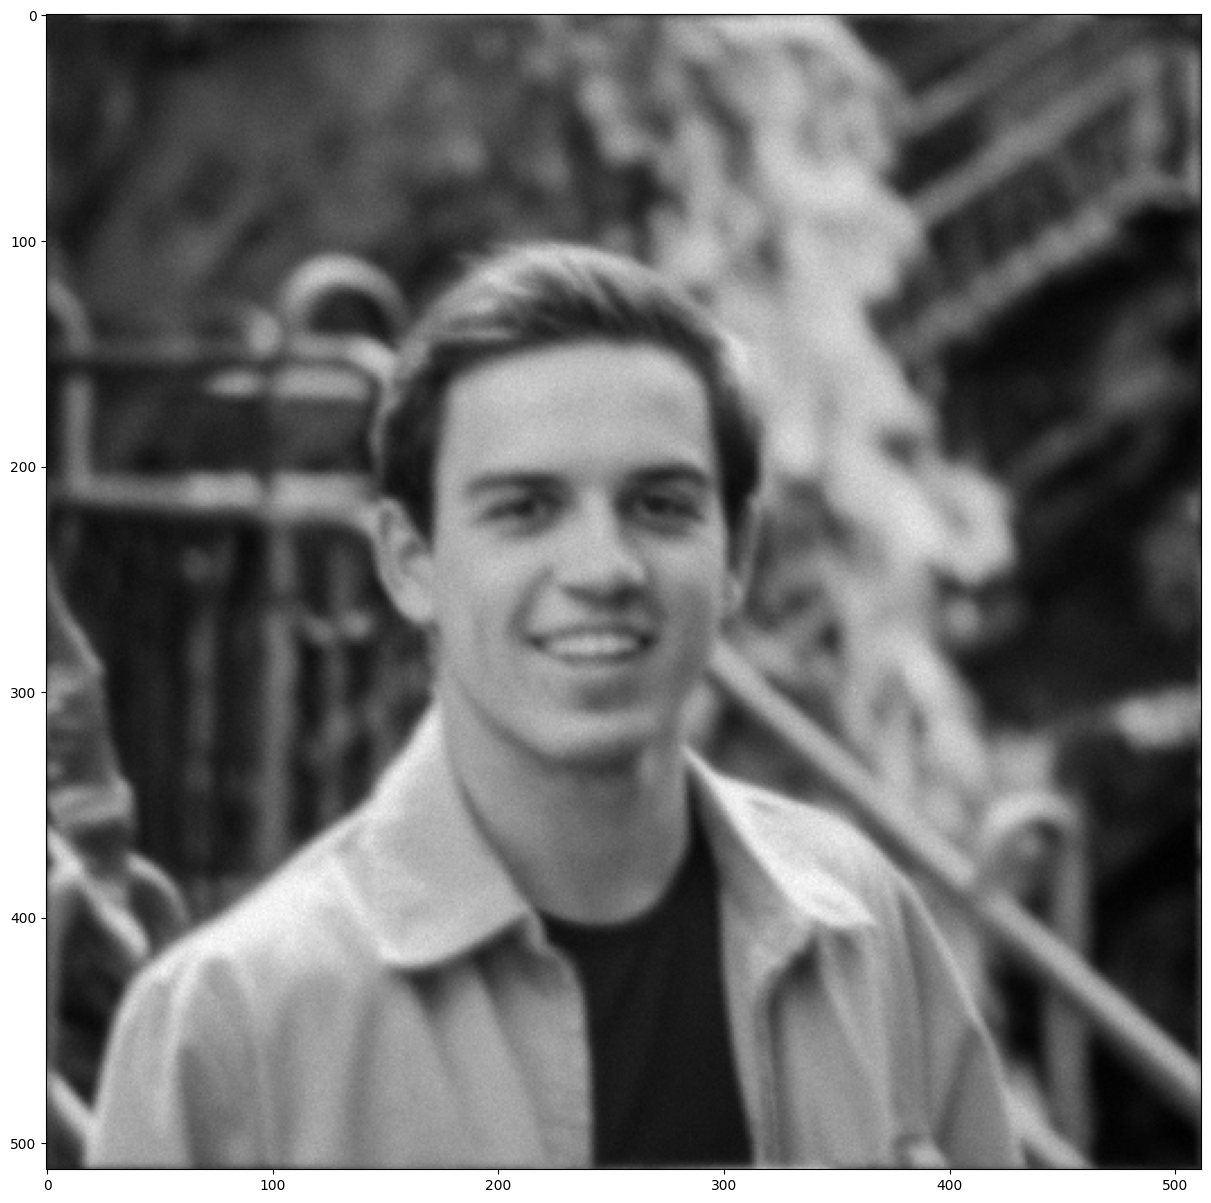

In [193]:
plt.figure(figsize=(15,15))
plt.imshow(im, cmap='gray')